True

In [2]:
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
import random
from save_and_load import *


candles = obj_load("NQ_1")
len(candles)

loading NQ_1


100000

In [3]:
# compute time offset
last_time = None
current_offset = 0
for candle in candles:

    if last_time != None and candle.t - (last_time - timedelta(hours = current_offset))  > timedelta(minutes = 50):
        target_hour = 18
        current_offset = target_hour - candle.t.hour
        if(current_offset > 12):
            current_offset-=24


    candle.t = candle.t + timedelta(hours = current_offset) 
    last_time = candle.t
candles[-1].t

datetime.datetime(2025, 1, 17, 16, 29)

In [4]:

class manager:

    index = 0
    
    current_candles = deque(maxlen = 30000)
    
    midnight_open = 0
    midnight_opening_range_low = 0
    midnight_opening_range_high = 0
    
    opening_range_gap_start_3 = 0
    opening_range_gap_ce_3 = 0
    opening_range_gap_end_3 = 0
    
    opening_range_gap_start_2 = 0
    opening_range_gap_ce_2 = 0
    opening_range_gap_end_2 = 0
    
    opening_range_gap_start_1 = 0
    opening_range_gap_ce_1 = 0
    opening_range_gap_end_1 = 0
    
    fp_low_3 = 0
    fp_ce_3 = 0
    fp_high_3 = 0
    
    fp_low_2 = 0
    fp_ce_2 = 0
    fp_high_2 = 0
    
    fp_low_1 = 0
    fp_ce_1 = 0
    fp_high_1 = 0
        
    last_settlement_price = 0


    def __init__(self):
        l = 60
        self.m1_candles = deque(maxlen = l)
        self.m5_candles = deque(maxlen = l)
        self.m15_candles = deque(maxlen = l)
        self.m60_candles = deque(maxlen = 1000)  
        self.d1_candles = deque(maxlen = 1000)   

    

    
    def push_m1_candle(self, __candle):
        candle = copy.deepcopy(__candle)
        candle_minute = candle.t.minute
        candle_hour = candle.t.hour

        self.m1_candles.append(candle)
    
        if(candle.t.hour == 0 and candle.t.minute == 0 and candle.t.second == 0):
            self.midnight_open  = candle.o
            self.midnight_opening_range_low = candle.l
            self.midnight_opening_range_high = candle.h
    
        if(candle.t.hour == 0 and candle.t.minute <= 30):
            self.midnight_opening_range_low = min(self.midnight_opening_range_low, candle.l)
            self.midnight_opening_range_high = max(self.midnight_opening_range_high, candle.h)
    
        
        if(candle.t.hour == 16 and candle.t.minute == 15 and candle.t.second == 0 and len(self.m1_candles)>1):
            last_candle = self.m1_candles[-2]
            self.last_settlement_price = last_candle.c
    
        if(candle.t.hour == 9 and candle.t.minute == 30 and candle.t.second == 0):
            opening_price = candle.o
            
            self.opening_range_gap_start_3 = self.opening_range_gap_start_2
            self.opening_range_gap_start_2 = self.opening_range_gap_start_1
            self.opening_range_gap_end_3 = self.opening_range_gap_end_2
            self.opening_range_gap_end_2 = self.opening_range_gap_end_1
            self.opening_range_gap_ce_3 = self.opening_range_gap_ce_2
            self.opening_range_gap_ce_2 = self.opening_range_gap_ce_1
    
            self.opening_range_gap_end_1 = opening_price
            self.opening_range_gap_start_1 = self.last_settlement_price
            self.opening_range_gap_ce_1 = (opening_price+self.last_settlement_price) / 2
            
    

        # m5 candles
        if len(self.m5_candles) > 0:
            last_minute = self.m5_candles[-1].t.minute
            last_hour = self.m5_candles[-1].t.hour
            minute_rounded = int(candle_minute/5) * 5
            if minute_rounded != last_minute or candle_hour != last_hour:
                
                c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
                self.m5_candles.append(c)
            else:
                self.m5_candles[-1].c = candle.c
                self.m5_candles[-1].h = max(candle.h, self.m5_candles[-1].h)
                self.m5_candles[-1].l = min(candle.l, self.m5_candles[-1].l)
        else:

            c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
            self.m5_candles.append(c)
            

       # m15 candles
        if len(self.m15_candles) > 0:
            last_minute = self.m15_candles[-1].t.minute
            last_hour = self.m15_candles[-1].t.hour
            minute_rounded = int(candle_minute/15) * 15
            if minute_rounded != last_minute or candle_hour != last_hour:
               
                c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
                self.m15_candles.append(c)
            else:
                self.m15_candles[-1].c = candle.c
                self.m15_candles[-1].h = max(candle.h, self.m15_candles[-1].h)
                self.m15_candles[-1].l = min(candle.l, self.m15_candles[-1].l)
        else:
            
            c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
            self.m15_candles.append(c)

        # m60 candles
        if len(self.m60_candles) > 0:
            last_minute = self.m60_candles[-1].t.minute
            last_hour = self.m60_candles[-1].t.hour
            
            if candle_hour != last_hour:
                
                c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
                self.m60_candles.append(c)
            else:
                self.m60_candles[-1].c = candle.c
                self.m60_candles[-1].h = max(candle.h, self.m60_candles[-1].h)
                self.m60_candles[-1].l = min(candle.l, self.m60_candles[-1].l)
        else:
           
            c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
            self.m60_candles.append(c)


       # d1 candles
        if len(self.d1_candles) > 0:
            last_candle_hour = self.m1_candles[-2].t.hour
            #print(candle_hour)
            if candle_hour != last_candle_hour and candle_hour == 18:
                
                c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
                self.d1_candles.append(c)
            else:
                self.d1_candles[-1].c = candle.c
                self.d1_candles[-1].h = max(candle.h, self.d1_candles[-1].h)
                self.d1_candles[-1].l = min(candle.l, self.d1_candles[-1].l)
        else:
            
            c = Candle(candle.o,candle.h,candle.l,candle.c,candle.t)
            self.d1_candles.append(c)


        pdas = [
            self.opening_range_gap_start_3,
            self.opening_range_gap_ce_3,
            self.opening_range_gap_end_3,
    
            self.opening_range_gap_start_2,
            self.opening_range_gap_ce_2,
            self.opening_range_gap_end_2,
    
            self.opening_range_gap_start_1,
            self.opening_range_gap_ce_1,
            self.opening_range_gap_end_1,
            ]

        ret_candles =       [
                self.m15_candles,
                 self.m5_candles,
                 self.m1_candles
        ]
        
        return [
            self.midnight_open, 
            self.midnight_opening_range_high,
            self.midnight_opening_range_low, 
            pdas,
    
            self.m1_candles[-1].c, 
            self.m1_candles[-1].t,
            
            ret_candles
        ]

      

In [5]:
def relative (value, center, r):
        return (value - center) / r
        
def ret_to_scaled_inputs(ret):
    
    midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
    
    center = (midnight_opening_range_high + midnight_opening_range_low) / 2
    r = (midnight_opening_range_high - midnight_opening_range_low) / 2
    
    pda_rel = []
    pda_rel.append(relative(midnight_open, center, r))
    for pda in pdas:
        pda_rel.append(relative(pda, center, r))
    pda_np = np.array(pda_rel)
    
    current_minutes = current_time.hour * 60 + current_time.minute
    
    charts_array = []
    for candlesticks in charts:
        charts_array.append([])
        for candle in candlesticks:
            o = relative(candle.o, center, r)
            h = relative(candle.h, center, r)
            l = relative(candle.l, center, r)
            c = relative(candle.c, center, r)
            charts_array[-1].append([o,h,l,c])
    
    m15_np = np.array(charts_array[0])
    m5_np = np.array(charts_array[1])
    m1_np = np.array(charts_array[2])

    return [m15_np, m5_np, m1_np, pda_np, current_minutes]

In [6]:
chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Input(shape = (60,4))

pdas = tf.keras.layers.Input(shape = (10,))

current_position = tf.keras.layers.Input(shape = (1,))
scaled_open_profit = tf.keras.layers.Input(shape = (1,))

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])

d = tf.keras.layers.Dense(1024, "relu")(c)
d = tf.keras.layers.Dense(1024, "relu")(d)
d = tf.keras.layers.Dense(1024, "relu")(d)

o = tf.keras.layers.Dense(2, "linear")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes, current_position, scaled_open_profit], outputs = o)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

In [8]:
m = manager()

current_position = 0
entry_price = 0

equity = 0
equity_L = [0]

cmm = 0.5

last_close = 0
last_state = None
last_action = 0

index = 0

def step():

    global index, last_close, last_state, last_action, current_position, entry_price, equity


    sarts = None
    while  sarts == None:
        
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = (midnight_opening_range_high - midnight_opening_range_low) / 2
    
        
        if(len(m.m15_candles) == 60):

            open_profit = (current_close - entry_price) * current_position
            equity += open_profit
            scaled_open_profit = open_profit / r
            
            state = ret_to_scaled_inputs(ret) + [current_position, scaled_open_profit]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos, open_profit = state
            
            if(last_state != None):
                diff = equity - equity_L[-1]
                equity_L.append(equity)
                reward =  (diff) / r
                terminal = 0
                if(index+1 == len(candles)):
                    terminal = 1
                
                sarts = last_state, last_action, reward, terminal, state
                
                
            output = model([
                tf.expand_dims(m15_np, 0),
                tf.expand_dims(m5_np, 0),
                tf.expand_dims(m1_np, 0),
                tf.expand_dims(pda_np, 0),
                tf.expand_dims(current_minutes, 0),
                tf.expand_dims(pos, 0),
                tf.expand_dims(open_profit, 0),
            ])
            
            last_action = np.argmax(output)
            last_close = current_close
            last_state = state
    
    
            if(last_action == 0 and current_position != -1):
                current_position = -1
                entry_price = current_close
                equity -= cmm
            if(last_action == 1 and current_position != 1):
                current_position = 1
                entry_price = current_close
                equity -= cmm
    
               
    
        index += 1
        if(index == len(candles)):
            index = 0
            current_position = 0
            entry_price = 0
            last_close = 0
            last_state = None
            last_action = 0
            print("env reset")
            
    return sarts

In [9]:
gamma = 0.99

In [10]:
m1 = np.eye(2, dtype="float32")
m1

array([[1., 0.],
       [0., 1.]], dtype=float32)

In [11]:
num_model_inputs = 7

In [12]:
@tf.function(reduce_retracing=True)
def get_target_q(next_states, rewards, terminals):
            estimated_q_values_next = model(next_states)
            q_batch = tf.math.reduce_max(estimated_q_values_next, axis=1)
            target_q_values = q_batch * gamma * (1-terminals) + rewards
            return target_q_values

@tf.function(reduce_retracing=True)
def tstep(states, masks, rewards, terminals, next_states):
    
    target_q_values = get_target_q(next_states, rewards, terminals)
    
    with tf.GradientTape() as t:
        model_return = model(states, training=True) 
        mask_return = model_return * masks
        estimated_q_values = tf.math.reduce_sum(mask_return, axis=1)
        #print(estimated_q_values, mask_return, model_return, masks)
        loss_e = tf.math.square(target_q_values - estimated_q_values)
        loss = tf.reduce_mean(loss_e)
    
    
    gradient = t.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    return loss, tf.reduce_mean(estimated_q_values)

In [13]:
def run():
    sarts = step()
    sarts_memory.append(sarts)

    sarts_sample = random.sample(sarts_memory, min(32, len(sarts_memory)))
    
    states = [x[0] for x in sarts_sample]
    actions = [x[1] for x in sarts_sample]
    rewards = np.array([x[2] for x in sarts_sample], dtype="float32")
    terminals = np.array([x[3] for x in sarts_sample], dtype="float32")
    next_states = [x[4] for x in sarts_sample]
    
    next_states_array = []
    for i in range(num_model_inputs):
        next_states_array.append(np.array([x[i] for x in next_states], dtype = "float32"))
    
    
    states_array = []
    for i in range(num_model_inputs):
        states_array.append(np.array([x[i] for x in states], dtype = "float32"))
    
    
    masks = np.array(m1[actions], dtype="float32")
    
    loss, q = tstep(states_array, masks, rewards, terminals, next_states_array)
    
    return loss, q, sarts[2], sarts[1]

In [14]:
sarts_memory = deque(maxlen = 50000)

ep_len = 1000

loss_mean = []
q_mean = []
rewards_mean = []

for _ in range(100):
    loss = []
    q = []
    rewards = []
    progbar = tf.keras.utils.Progbar(ep_len)
    for i in range(ep_len):
        c_loss, c_q, c_rewards, c_action = run()
        loss.append(c_loss)
        q.append(c_q)
        rewards.append(c_rewards)
        
        progbar.update(i+1, values = [("loss", c_loss), ("qv", c_q), ("reward", c_rewards), ("avg_action", c_action)])
    
    loss_mean.append(np.mean(loss))
    q_mean.append(np.mean(q))
    rewards_mean.append(np.mean(rewards))

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - loss: 59.4432 - qv: 183.2645 - reward: 1.1719 - avg_action: 0.6410  
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 3650450.7500 - qv: 11179.6611 - reward: -0.0795 - avg_action: 0.3990   
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - loss: 31827.6484 - qv: 2738.7380 - reward: -0.4150 - avg_action: 0.4480
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 38s 38ms/step - loss: 61496.7773 - qv: 2900.6421 - reward: -0.5362 - avg_action: 0.4540
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - loss: 378550.5312 - qv: 5754.4160 - reward: -0.4595 - avg_action: 0.6340     
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - loss: 52485.9375 - qv: 3227.4153 - reward: 0.0888 - avg_action: 0.3650   
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - loss: 30455.1680 - qv: 2469.7537 - reward: 1.8933 - avg_action: 0.3640
 227/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 37ms/step - loss: 5864.1392 - qv: 1301.7126 - reward: -0.0254 - avg_action: 0.4405 

KeyboardInterrupt: 

np.float64(16065.5)

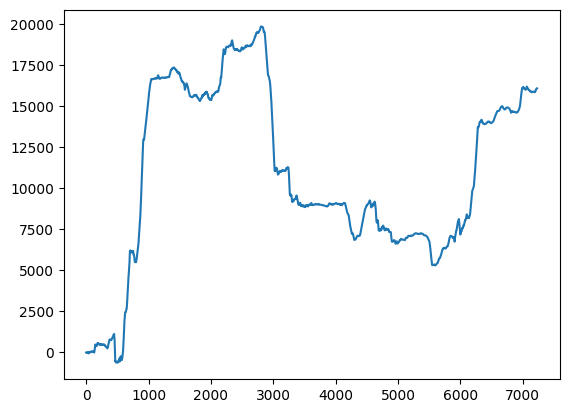

In [15]:
import matplotlib.pyplot as plt
plt.plot(equity_L)
equity